# utils & framework

In [30]:
from typing import List, Any
from collections.abc import Iterable

import scipy.constants
from IPython.core.display import Markdown
from sympy import *
from sympy.vector import *

tag_id = 0
conditions = {}
values = {}
formulas_names = {}
restore_stack = []


def reset():
    global tag_id, conditions, values, formulas_names
    if restore_stack:
        state = restore_stack[-1]
        tag_id = state['tag_id']
        conditions = state['conditions'].copy()
        values = state['values'].copy()
        formulas_names = state['formulas_names'].copy()


def push_state():
    global restore_stack
    restore_stack.append({
        'tag_id': tag_id,
        'conditions': conditions.copy(),
        'values': values.copy(),
        'formulas_names': formulas_names.copy()
    })


def pop_state():
    global restore_stack
    return restore_stack.pop()


def save_as_condition(condition):
    global tag_id, conditions
    cached_condition_id = tag_id
    conditions[tag_id] = condition
    tag_id += 1
    return cached_condition_id


def substitute_values(expression, mask=None):
    while True:
        left = False
        items = values.items() if mask is None else filter(lambda item: item[0] in mask, values.items())
        for (key, value) in items:
            before = str(expression)
            expression = expression.subs(key, value)
            expression = simplify(expression)
            if str(expression) != before:
                left = True
        if not left:
            break

    return expression


def save_as_variable(symbol, value):
    global values
    if symbol in values.keys():
        raise ValueError(f"variable {symbol} already exists")
    values[symbol] = substitute_values(S(value))


def save_as_formula_name(symbol, formula):
    global tag_id, formulas_names
    tag_id += 1
    if symbol in formulas_names.keys():
        raise ValueError(f"formula {symbol} already exists")
    formulas_names[symbol] = formula


def beautiful_print(expression, message="", tag=None):
    expression = expression if isinstance(expression, str) else latex(expression)
    inline = not message.endswith('$')
    tag_str = f'\\tag{{{tag}}}' if tag is not None else ""
    if inline:
        full_latex = message + '$' + expression + '$'
    else:
        full_latex = message + '$' + expression + tag_str + '$$'
    display(Markdown(full_latex))


def beautiful_answer(expression, message="$", f: bool = False):
    symbol= expression
    expression = spf(expression)
    expression = expression.evalf() if f else expression
    beautiful_print(Eq(symbol,expression,evaluate=false), message, tag="answer")


def beautiful_peek(symbol, message="$", tag=None):
    value = substitute_values(symbol)
    beautiful_print(Eq(symbol, value, evaluate=False), message, tag)


def beautiful_solve(cond, variables, apply: dict = None):
    cond = [cond] if not isinstance(cond, Iterable) else cond
    display(Markdown(f"${','.join(f"\\left ( {i} \\right ) " for i in cond)} \\Longrightarrow$"))

    variables = [variables] if not isinstance(variables, Iterable) else variables

    apply = apply if apply is not None else {}

    cond = tuple(map(lambda i: conditions[i].subs(apply), cond))
    solution = solve(cond, tuple(variables), dict=True)[0]
    conclusions = []
    for (variable, conclusion) in solution.items():
        beautiful_print(Eq(variable, conclusion), "$")
        save_as_variable(variable, conclusion)
        conclusions.append(conclusion)


def beautiful_condition(expression, message="$"):
    beautiful_print(expression(False) if callable(expression) else expression, message, tag_id)
    return save_as_condition(expression(True) if callable(expression) else expression)


def beautiful_compute(symbol, expression, message="$", tag=None):
    symbol = symbols(symbol) if isinstance(symbol, str) else symbol
    global tag_id
    beautiful_print(Eq(symbol, expression(False) if callable(expression) else expression, evaluate=False), message,
                    tag_id if tag else None)
    if tag:
        tag_id += 1
    save_as_variable(symbol, expression(True) if callable(expression) else expression)
    return symbol


def beautiful_formula(symbol: str, expression: object, message: object = "$", ) -> Any:
    beautiful_print(f"{symbol}=" + latex(expression), message, tag_id)
    save_as_formula_name(expression, symbol)
    return expression


def beautiful_at(formula, subs: dict, message="$", tag: bool = None):
    result = simplify(formula.subs(subs))
    param = '\\,'.join(f"{latex(item[0])}={latex(item[1])}" for item in subs.items())
    beautiful_print(formulas_names[formula] + f"\\bigg|_{{{param}}}=" + latex(result), message, tag)
    return result


def spf(expression):
    expression = substitute_values(expression)
    expression = simplify(expression)
    return expression


class D:
    def __init__(self, symbol: Symbol, name: str = None):
        symbol = 'd' + latex(symbol) if name is None else name
        self.symbol = Symbol(symbol)

    def __enter__(self):
        return self.symbol

    def __exit__(self, type, value, traceback):
        save_as_variable(self.symbol, 1)


def map_vector(vec, func):
    return sum(
        # 0 is i/j/k sharp, 1 is expr
        map(lambda item: func(item[1]) * item[0], vec.components.items()),
        Vector.zero
    )


def series_vector(vec, param, x0=0, n=2):
    return map_vector(vec, lambda e: series(e, param, x0, n).removeO())


def integrate_vector(vec, param):
    return map_vector(vec, lambda e: integrate(e, param))


def beautiful_vector(xi=0, yj=0, zk=0):
    xi = Symbol(xi) if isinstance(xi, str) else xi
    yj = Symbol(yj) if isinstance(yj, str) else yj
    zk = Symbol(zk) if isinstance(zk, str) else zk
    return xi * coord.i + yj * coord.j + zk * coord.k


coord = CoordSys3D('')


def refine_piecewise(pw_expr, assume):
    """Refine a Piecewise expression with given assumptions."""
    if not isinstance(pw_expr, Piecewise):
        return refine(pw_expr, assume)

    for expr_val, cond in pw_expr.args:
        if cond:  # Default/otherwise branch
            return refine(expr_val, assume)
        elif ask(cond, assume):
            return refine(expr_val, assume)

    # If no branch can be definitively chosen, refine each branch
    refined_args = [(refine(expr_val, assume), cond)
                    for expr_val, cond in pw_expr.args]
    return Piecewise(*refined_args)


## Common

In [31]:
epsilon = symbols('epsilon_0', positive=True)
k = 1 / (4 * pi * epsilon)
charge = symbols('q')
x = coord.x
y = coord.y
z = coord.z
pos = x * coord.i + y * coord.j + z * coord.k
E = beautiful_formula('E', k * charge * pos / pos.magnitude() ** 3, "by Coulomb's law:$")
electric_flux = Symbol('phi_e')
enclosed_charge_sum = Symbol('Q_{sum}')
Gauss_law = beautiful_condition(Eq(electric_flux, enclosed_charge_sum / epsilon), "by Gauss's law:$")
def fn_potential(q,r):
    return k*q/r
P = beautiful_formula('\\varphi', fn_potential(charge , pos.magnitude()), 'electric potential:$')
def save_common_consts():
    save_as_variable(epsilon, scipy.constants.epsilon_0)
    save_as_variable(pi, scipy.constants.pi)
push_state()

by Coulomb's law:$$E=\left(\frac{\mathbf{{x}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{i}_{}} + \left(\frac{\mathbf{{y}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{j}_{}} + \left(\frac{\mathbf{{z}_{}} q}{4 \pi \epsilon_{0} \left(\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}\right)^{\frac{3}{2}}}\right)\mathbf{\hat{k}_{}}\tag{0}$$

by Gauss's law:$$\phi_{e} = \frac{Q_{sum}}{\epsilon_{0}}\tag{1}$$

electric potential:$$\varphi=\frac{q}{4 \pi \epsilon_{0} \sqrt{\mathbf{{x}_{}}^{2} + \mathbf{{y}_{}}^{2} + \mathbf{{z}_{}}^{2}}}\tag{2}$$

# 14.2
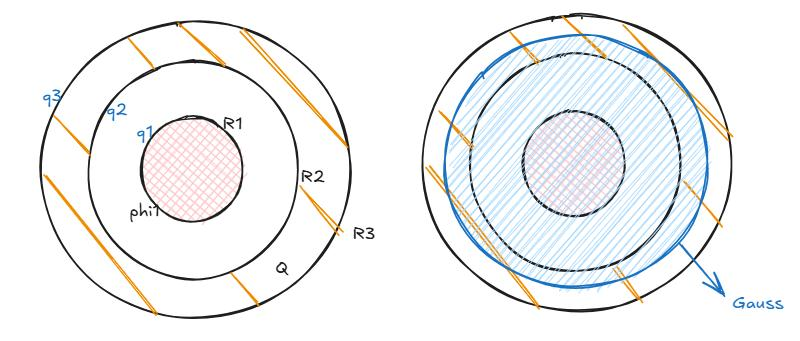

In [32]:
def t142():
    reset()
    q1= Symbol('q_1')
    q2 = Symbol('q_2')
    q3 = Symbol('q_3')
    QQ = Symbol('Q')
    phi_1 = Symbol('phi_1')
    R_1 = Symbol('R_1')
    R_2 = Symbol('R_2')
    R_3 = Symbol('R_3')
    
    r = Symbol('r',positive=True)
    
    c1 = beautiful_condition(Eq(q3+q2,QQ),"given:$")
    c2= beautiful_condition(Eq(phi_1,fn_potential(q1,R_1)+fn_potential(q2,R_2)+fn_potential(q3,R_3)),"given:$")
    c3 = beautiful_condition(Eq(q1+q2,0),"by Gauss law:$")
    
    beautiful_solve([c1,c2,c3],[q1,q2,q3])
    ppp=beautiful_compute(Function('phi')(r),Piecewise((fn_potential(q1,r)+fn_potential(q2,r)+fn_potential(q3,r),r>R_3)
                                                   ,(fn_potential(q1,r)+fn_potential(q2,r)+fn_potential(q3,R_3),(r<=R_3)&(r>R_2))
                                                   ,(fn_potential(q1,r)+fn_potential(q2,R_2)+fn_potential(q3,R_3),(r<=R_2)&(r>R_1))
                                                   ,(phi_1,True)
                                                   ),"get the potential:$")
    beautiful_answer(ppp,"inlined:$")
    beautiful_peek(-diff(ppp,r),"and $E$:$")

t142()

given:$$q_{2} + q_{3} = Q\tag{3}$$

given:$$\phi_{1} = \frac{q_{3}}{4 \pi R_{3} \epsilon_{0}} + \frac{q_{2}}{4 \pi R_{2} \epsilon_{0}} + \frac{q_{1}}{4 \pi R_{1} \epsilon_{0}}\tag{4}$$

by Gauss law:$$q_{1} + q_{2} = 0\tag{5}$$

$\left ( 3 \right ) ,\left ( 4 \right ) ,\left ( 5 \right )  \Longrightarrow$

$$q_{1} = \frac{- Q R_{1} R_{2} + 4 \pi R_{1} R_{2} R_{3} \epsilon_{0} \phi_{1}}{R_{1} R_{2} - R_{1} R_{3} + R_{2} R_{3}}$$

$$q_{2} = \frac{Q R_{1} R_{2} - 4 \pi R_{1} R_{2} R_{3} \epsilon_{0} \phi_{1}}{R_{1} R_{2} - R_{1} R_{3} + R_{2} R_{3}}$$

$$q_{3} = \frac{- Q R_{1} R_{3} + Q R_{2} R_{3} + 4 \pi R_{1} R_{2} R_{3} \epsilon_{0} \phi_{1}}{R_{1} R_{2} - R_{1} R_{3} + R_{2} R_{3}}$$

get the potential:$$\phi{\left(r \right)} = \begin{cases} \frac{q_{1}}{4 \pi \epsilon_{0} r} + \frac{q_{2}}{4 \pi \epsilon_{0} r} + \frac{q_{3}}{4 \pi \epsilon_{0} r} & \text{for}\: R_{3} < r \\\frac{q_{1}}{4 \pi \epsilon_{0} r} + \frac{q_{2}}{4 \pi \epsilon_{0} r} + \frac{q_{3}}{4 \pi R_{3} \epsilon_{0}} & \text{for}\: R_{2} < r \\\frac{q_{1}}{4 \pi \epsilon_{0} r} + \frac{q_{3}}{4 \pi R_{3} \epsilon_{0}} + \frac{q_{2}}{4 \pi R_{2} \epsilon_{0}} & \text{for}\: R_{1} < r \\\phi_{1} & \text{otherwise} \end{cases}$$

inlined:$$\phi{\left(r \right)} = \begin{cases} \frac{R_{3} \left(- Q R_{1} + Q R_{2} + 4 \pi R_{1} R_{2} \epsilon_{0} \phi_{1}\right)}{4 \pi \epsilon_{0} r \left(R_{1} R_{2} - R_{1} R_{3} + R_{2} R_{3}\right)} & \text{for}\: R_{3} < r \\\frac{- Q R_{1} + Q R_{2} + 4 \pi R_{1} R_{2} \epsilon_{0} \phi_{1}}{4 \pi \epsilon_{0} \left(R_{1} R_{2} - R_{1} R_{3} + R_{2} R_{3}\right)} & \text{for}\: R_{2} < r \\\frac{- R_{1} R_{2} \left(Q - 4 \pi R_{3} \epsilon_{0} \phi_{1}\right) + R_{1} r \left(Q - 4 \pi R_{3} \epsilon_{0} \phi_{1}\right) + r \left(- Q R_{1} + Q R_{2} + 4 \pi R_{1} R_{2} \epsilon_{0} \phi_{1}\right)}{4 \pi \epsilon_{0} r \left(R_{1} R_{2} - R_{1} R_{3} + R_{2} R_{3}\right)} & \text{for}\: R_{1} < r \\\phi_{1} & \text{otherwise} \end{cases}\tag{answer}$$

and $E$:$$- \frac{d}{d r} \phi{\left(r \right)} = \begin{cases} \frac{R_{3} \left(- Q R_{1} + Q R_{2} + 4 \pi R_{1} R_{2} \epsilon_{0} \phi_{1}\right)}{4 \pi \epsilon_{0} r^{2} \left(R_{1} R_{2} - R_{1} R_{3} + R_{2} R_{3}\right)} & \text{for}\: R_{3} < r \\0 & \text{for}\: R_{2} < r \\\frac{R_{1} R_{2} \left(- Q + 4 \pi R_{3} \epsilon_{0} \phi_{1}\right)}{4 \pi \epsilon_{0} r^{2} \left(R_{1} R_{2} - R_{1} R_{3} + R_{2} R_{3}\right)} & \text{for}\: R_{1} < r \\0 & \text{otherwise} \end{cases}$$

# 143
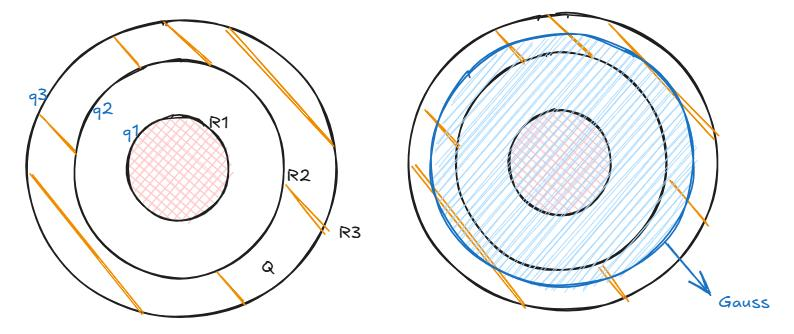

In [33]:
def t143():
    reset()
    print("sub question(1)")
    q1 = Symbol('Q_A')
    q2 = Symbol('q_2')
    q3 = Symbol('q_3')
    QQ = Symbol('Q_B')
    R_1 = Symbol('R_1')
    R_2 = Symbol('R_2')
    R_3 = Symbol('R_3')

    r = Symbol('r', positive=True)

    c1 = beautiful_condition(Eq(q3 + q2, QQ), "given:$")

    c3 = beautiful_condition(Eq(q1 + q2, 0), "by Gauss law:$")

    beautiful_solve([c1, c3], [q2, q3])
    save_as_variable(epsilon,scipy.constants.epsilon_0)
    save_as_variable(q1,3E-8)
    save_as_variable(QQ,2E-8)
    save_as_variable(R_1,0.06)
    save_as_variable(R_2,0.08)
    save_as_variable(R_3,0.10)
    save_as_variable(pi,3.14)
    beautiful_answer(q2,"inlined:$")
    beautiful_answer(q3,"inlined:$")
    ppppp = beautiful_compute(Symbol('\\phi_{A}'),fn_potential(q1,R_1)+fn_potential(q2,R_2)+fn_potential(q3,R_3),)
    beautiful_answer(ppppp,"inlined:$")
    ppppp = beautiful_compute(Symbol('\\phi_{B}'),fn_potential(q1,R_3)+fn_potential(q2,R_3)+fn_potential(q3,R_3),)
    beautiful_answer(ppppp,"inlined:$")
    # ppp = beautiful_compute(Function('phi')(r),
    #                         Piecewise((fn_potential(q1, r) + fn_potential(q2, r) + fn_potential(q3, r), r > R_3)
    #                                   , (fn_potential(q1, r) + fn_potential(q2, r) + fn_potential(q3, R_3),
    #                                      (r <= R_3) & (r > R_2))
    #                                   , (fn_potential(q1, r) + fn_potential(q2, R_2) + fn_potential(q3, R_3),
    #                                      (r <= R_2) & (r > R_1))
    #                                   , (fn_potential(q1,R_1)+ fn_potential(q2,R_2)+ fn_potential(q3,R_3), True)
    #                                   ), "get the potential:$")
    # beautiful_answer(ppp, "inlined:$")
    # beautiful_peek(-diff(ppp, r), "and $E$:$")
    
    reset()
    print("sub question(2)")
   
    
    nq1= Symbol('Q_{newA}')
    nq2 = Symbol('Q_{new2}')
    nq3 = Symbol('Q_{new3}')
    c5 = beautiful_condition(Eq(q1 + q2, 0), "by Gauss law:$")
    beautiful_solve(c5,q2)
    beautiful_compute(q3,0,"by contact ground:$")
    
    c6 = beautiful_condition(Eq(nq2+nq3,q2),"outer sphere charge sum:$")
    c7 = beautiful_condition(Eq(fn_potential(nq1,R_1)+ fn_potential(nq2,R_2)+fn_potential(nq3,R_3),0),"by contact ground:$")

    c8 = beautiful_condition(Eq(nq1 + nq2, 0), "by Gauss law:$")
    beautiful_solve([c6,c7,c8],[nq1,nq2
                        ,nq3])
    save_common_consts()
    save_as_variable(q1,3E-8)
    save_as_variable(QQ,2E-8)
    save_as_variable(R_1,0.06)
    save_as_variable(R_2,0.08)
    save_as_variable(R_3,0.10)
    
    beautiful_answer(nq1,"inlined:$")
    beautiful_answer(nq2,"inlined:$")
    beautiful_answer(nq3,"inlined:$")
    ppppp = beautiful_compute(Symbol('\\phi_{A}'),fn_potential(nq1,R_1)+fn_potential(nq2,R_2)+fn_potential(nq3,R_3),)
    beautiful_answer(ppppp,"inlined:$")
    ppppp = beautiful_compute(Symbol('\\phi_{B}'),fn_potential(nq1,R_3)+fn_potential(nq2,R_3)+fn_potential(nq3,R_3),)
    beautiful_answer(ppppp,"inlined:$")




t143()


sub question(1)


given:$$q_{2} + q_{3} = Q_{B}\tag{3}$$

by Gauss law:$$Q_{A} + q_{2} = 0\tag{4}$$

$\left ( 3 \right ) ,\left ( 4 \right )  \Longrightarrow$

$$q_{2} = - Q_{A}$$

$$q_{3} = Q_{A} + Q_{B}$$

inlined:$$q_{2} = -3.0 \cdot 10^{-8}\tag{answer}$$

inlined:$$q_{3} = 5.0 \cdot 10^{-8}\tag{answer}$$

$$\phi_{A} = \frac{Q_{A}}{4 \pi R_{1} \epsilon_{0}} + \frac{q_{3}}{4 \pi R_{3} \epsilon_{0}} + \frac{q_{2}}{4 \pi R_{2} \epsilon_{0}}$$

inlined:$$\phi_{A} = 5620.06900182962\tag{answer}$$

$$\phi_{B} = \frac{Q_{A}}{4 \pi R_{3} \epsilon_{0}} + \frac{q_{2}}{4 \pi R_{3} \epsilon_{0}} + \frac{q_{3}}{4 \pi R_{3} \epsilon_{0}}$$

inlined:$$\phi_{B} = 4496.05520146369\tag{answer}$$

sub question(2)


by Gauss law:$$Q_{A} + q_{2} = 0\tag{3}$$

$\left ( 3 \right )  \Longrightarrow$

$$q_{2} = - Q_{A}$$

by contact ground:$$q_{3} = 0$$

outer sphere charge sum:$$Q_{new2} + Q_{new3} = q_{2}\tag{4}$$

by contact ground:$$\frac{Q_{new2}}{4 \pi R_{2} \epsilon_{0}} + \frac{Q_{new3}}{4 \pi R_{3} \epsilon_{0}} + \frac{Q_{newA}}{4 \pi R_{1} \epsilon_{0}} = 0\tag{5}$$

by Gauss law:$$Q_{new2} + Q_{newA} = 0\tag{6}$$

$\left ( 4 \right ) ,\left ( 5 \right ) ,\left ( 6 \right )  \Longrightarrow$

$$Q_{new2} = \frac{R_{1} R_{2} q_{2}}{R_{1} R_{2} - R_{1} R_{3} + R_{2} R_{3}}$$

$$Q_{new3} = \frac{- R_{1} R_{3} q_{2} + R_{2} R_{3} q_{2}}{R_{1} R_{2} - R_{1} R_{3} + R_{2} R_{3}}$$

$$Q_{newA} = - \frac{R_{1} R_{2} q_{2}}{R_{1} R_{2} - R_{1} R_{3} + R_{2} R_{3}}$$

inlined:$$Q_{newA} = 2.11764705882353 \cdot 10^{-8}\tag{answer}$$

inlined:$$Q_{new2} = -2.11764705882353 \cdot 10^{-8}\tag{answer}$$

inlined:$$Q_{new3} = -8.82352941176471 \cdot 10^{-9}\tag{answer}$$

$$\phi_{A} = \frac{Q_{new2}}{4 \pi R_{2} \epsilon_{0}} + \frac{Q_{new3}}{4 \pi R_{3} \epsilon_{0}} + \frac{Q_{newA}}{4 \pi R_{1} \epsilon_{0}}$$

inlined:$$\phi_{A} = 0\tag{answer}$$

$$\phi_{B} = \frac{Q_{new2}}{4 \pi R_{3} \epsilon_{0}} + \frac{Q_{new3}}{4 \pi R_{3} \epsilon_{0}} + \frac{Q_{newA}}{4 \pi R_{3} \epsilon_{0}}$$

inlined:$$\phi_{B} = -793.019275250365\tag{answer}$$

# 14.5

In [34]:
def t145():
    reset()
    sigma_1 = Symbol('sigma_1')
    sigma_2 = Symbol('sigma_2')
    sigma_3 = Symbol('sigma_3')
    sigma_4 = Symbol('sigma_4')
    sigma_5 = Symbol('sigma_5')
    sigma_6 = Symbol('sigma_6')
    sum_mid = Symbol('sum_mid')
    
    d1= Symbol('d1')
    d2 = Symbol('d2')
    d3 = Symbol('d3')
    
    beautiful_compute(d3,d2-d1,"by geometry:$")
    c1=beautiful_condition(Eq(sigma_3+ sigma_4, sum_mid),"given:$")
    c2= beautiful_condition(Eq(sigma_2+sigma_3,0),"by Gauss law to Gauss surface 1:$")
    c3= beautiful_condition(Eq(sigma_4+sigma_5,0),"by Gauss law to Gauss surface 2:$")
    c4 = beautiful_condition(Eq(sigma_1+sigma_2+sigma_5+sigma_6,0),"by connection of board 1 and 3:$")
    c5 = beautiful_condition(Eq((sigma_6+sigma_5)*d2 + (sigma_4+ sigma_3)*(d1-d3)+(sigma_1+ sigma_2)*(-d2),0),"by connection of board 1 and 3, equal potential:$")
    c6= beautiful_condition(Eq(sigma_1+ sigma_2+ sigma_3 , sigma_4+ sigma_5+ sigma_6), "by inside the mid board  $E$ is zero:$")

    beautiful_solve([c1,c2,c3,c4,c5,c6],[sigma_1,sigma_2,sigma_3,sigma_4,sigma_5,sigma_6])

    save_as_variable(sum_mid,1.3E-5)
    save_as_variable(d1,0.05)
    save_as_variable(d2,0.08)

    beautiful_answer(sigma_1,"inlined:$")
    beautiful_answer(sigma_2)
    beautiful_answer(sigma_3)
    beautiful_answer(sigma_4)
    beautiful_answer(sigma_5)
    beautiful_answer(sigma_6)
    
    
t145()

by geometry:$$d_{3} = - d_{1} + d_{2}$$

given:$$\sigma_{3} + \sigma_{4} = sum_{mid}\tag{3}$$

by Gauss law to Gauss surface 1:$$\sigma_{2} + \sigma_{3} = 0\tag{4}$$

by Gauss law to Gauss surface 2:$$\sigma_{4} + \sigma_{5} = 0\tag{5}$$

by connection of board 1 and 3:$$\sigma_{1} + \sigma_{2} + \sigma_{5} + \sigma_{6} = 0\tag{6}$$

by connection of board 1 and 3, equal potential:$$- d_{2} \left(\sigma_{1} + \sigma_{2}\right) + d_{2} \left(\sigma_{5} + \sigma_{6}\right) + \left(d_{1} - d_{3}\right) \left(\sigma_{3} + \sigma_{4}\right) = 0\tag{7}$$

by inside the mid board  $E$ is zero:$$\sigma_{1} + \sigma_{2} + \sigma_{3} = \sigma_{4} + \sigma_{5} + \sigma_{6}\tag{8}$$

$\left ( 3 \right ) ,\left ( 4 \right ) ,\left ( 5 \right ) ,\left ( 6 \right ) ,\left ( 7 \right ) ,\left ( 8 \right )  \Longrightarrow$

$$\sigma_{1} = \frac{sum_{mid}}{2}$$

$$\sigma_{2} = \frac{d_{1} sum_{mid} - d_{2} sum_{mid} - d_{3} sum_{mid}}{2 d_{2}}$$

$$\sigma_{3} = \frac{- d_{1} sum_{mid} + d_{2} sum_{mid} + d_{3} sum_{mid}}{2 d_{2}}$$

$$\sigma_{4} = \frac{d_{1} sum_{mid} + d_{2} sum_{mid} - d_{3} sum_{mid}}{2 d_{2}}$$

$$\sigma_{5} = \frac{- d_{1} sum_{mid} - d_{2} sum_{mid} + d_{3} sum_{mid}}{2 d_{2}}$$

$$\sigma_{6} = \frac{sum_{mid}}{2}$$

inlined:$$\sigma_{1} = 6.5 \cdot 10^{-6}\tag{answer}$$

$$\sigma_{2} = -4.875 \cdot 10^{-6}\tag{answer}$$

$$\sigma_{3} = 4.875 \cdot 10^{-6}\tag{answer}$$

$$\sigma_{4} = 8.125 \cdot 10^{-6}\tag{answer}$$

$$\sigma_{5} = -8.125 \cdot 10^{-6}\tag{answer}$$

$$\sigma_{6} = 6.5 \cdot 10^{-6}\tag{answer}$$

# 14.6
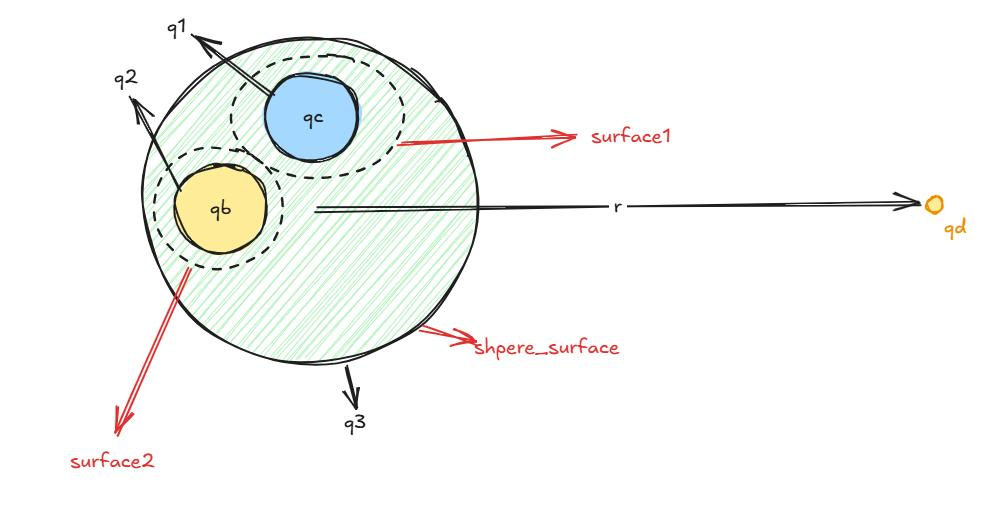

In [36]:
def t146():
    reset()
    q1= Symbol('q_1')
    q2 = Symbol('q_2')
    q3 = Symbol('q_3')
    qb = Symbol('q_b')
    qc = Symbol('q_c')
    qd = Symbol('q_d')

    display(Markdown("## take surface1, for inside, the outer world equals nothing , that means , the $q_1$ should distributes evenly on the inner sphere, and apply **no** force to $q_c$"))
    beautiful_compute('F_c',0,"that is :$",tag= "answer")
    display(Markdown("## that is same to $q_b$"))
    beautiful_compute('F_b',0,tag= "answer")

    beautiful_compute(q1,-qc, "apply Gauss law to surface1:$")
    beautiful_compute(q2,-qb,"apply Gauss law to surface2:$")
    beautiful_compute(q3,-q1-q2,"by zero charge sum:$")
    r= Symbol('r')
    fd=beautiful_compute(Symbol('F_{d}'), k* q3*qd /r**2,"as $q_d$ is far away from the sphere, we can approximately assume A as a point charge with $q_3$, and compute $E$:$")
    beautiful_answer(fd,"inlined:$")
t146()

## take surface1, for inside, the outer world equals nothing , that means , the $q_1$ should distributes evenly on the inner sphere, and apply **no** force to $q_c$

that is :$$F_{c} = 0\tag{3}$$

## that is same to $q_b$

$$F_{b} = 0\tag{4}$$

apply Gauss law to surface1:$$q_{1} = - q_{c}$$

apply Gauss law to surface2:$$q_{2} = - q_{b}$$

by zero charge sum:$$q_{3} = - q_{1} - q_{2}$$

as $q_d$ is far away from the sphere, we can approximately assume A as a point charge with $q_3$, and compute $E$:$$F_{d} = \frac{q_{3} q_{d}}{4 \pi \epsilon_{0} r^{2}}$$

inlined:$$F_{d} = \frac{q_{d} \left(q_{b} + q_{c}\right)}{4 \pi \epsilon_{0} r^{2}}\tag{answer}$$